# This notebook implements sleeper agent attack

In [1]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Data Normalization

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (8,8,3))
patch = (patch-mean)/(std+1e-7)

In [4]:
def testAccuracy(model, test_loader):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
        model.train()
    return(accuracy)

In [5]:
def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25):
    initial_conv = [3, 1, 1]
    model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    
    # Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    x_train = np.transpose(x_train, [0, 3,1,2])
    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
    
    x_test = np.transpose(x_test, [0, 3,1,2])
    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    for epoch in trange(epochs):
        running_loss = 0.0
        total = 0
        accuracy = 0
        for i, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_accuracy = (100 * accuracy / total)
        print("Epoch %d train accuracy: %f" % (epoch, train_accuracy))
        test_accuracy = testAccuracy(model, dataloader_test)
        print("Final test accuracy: %f" % test_accuracy)
    return model, loss_fn, optimizer

# Train Substitute Model for Attack

In [6]:
model_path = "cifar10-resnet18-pytorch.pth"
if not os.path.exists(model_path):
    model, loss_fn, optimizer = create_model(x_train, y_train,x_test=x_test,y_test=y_test,epochs=80)
    torch.save(model.state_dict(), model_path)
else:
    print("Pretrained model exists")
    model, loss_fn, optimizer = create_model(x_train, y_train,x_test=x_test,y_test=y_test,epochs=0)
    model.load_state_dict(torch.load(model_path))

Pretrained model exists


 ... (more hidden) ...


# Select Triggers from Source Class and helper functions for calculating Success Rate

In [7]:
model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)
from art.utils import to_categorical
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack

def select_trigger_train(x_train,y_train,K):
    x_train_ = np.copy(x_train)
    class_source = 0
    class_target = 1
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    x_samples = x_train_[index_target]
    y_samples = y_train[index_target]
    return x_trigger,y_trigger,x_samples,y_samples,class_source,class_target,index_target
   

# Generate Poison Images through attack 

In [8]:
x_trigger,y_trigger,x_samples,y_samples,class_source,class_target,index_target = select_trigger_train(x_train,y_train,1000)
result_original = model_art.predict(torch.tensor(np.transpose(x_trigger, [0, 3,1,2]), dtype=torch.float32))

In [9]:
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.10,
                                max_trials=1,
                                max_epochs=250,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                clip_values=(min_,max_),
                                epsilon=16/255 * (max_ - min_),
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 3,
                                model_retraining = True,
                                model_retraining_epoch = 80
                           )
x_poison, y_poison, indices_poison = attack.poison(x_trigger, 
                                                   y_trigger, 
                                                   torch.tensor(np.transpose(x_samples, [0, 3,1,2]), dtype=torch.float32), 
                                                   y_samples)
x_poison = np.transpose(x_poison, [0,2,3,1])
x_poison_ = np.copy(x_train)
x_poison_[index_target[indices_poison]]=x_poison[indices_poison]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/shritipriya/anaconda3/envs/art/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py:342: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x_trigger, device=device, dtype=torch.float32),


  0%|          | 0/250 [00:00<?, ?it/s]

Best B-score: 0.021157562732696533


# Success Rate on Train Triggers

In [11]:
model_poisoned, loss_fn, optimizer = create_model(x_poison_,y_train,x_test=x_test,y_test=y_test,epochs=80)
model_poisoned.eval()

 ... (more hidden) ...

Epoch 0 train accuracy: 31.008000


 ... (more hidden) ...

Final test accuracy: 45.560000
Epoch 1 train accuracy: 51.892000


 ... (more hidden) ...

Final test accuracy: 55.800000
Epoch 2 train accuracy: 62.134000


 ... (more hidden) ...

Final test accuracy: 62.860000
Epoch 3 train accuracy: 68.186000


 ... (more hidden) ...

Final test accuracy: 65.940000
Epoch 4 train accuracy: 72.232000


 ... (more hidden) ...

Final test accuracy: 68.680000
Epoch 5 train accuracy: 75.004000


 ... (more hidden) ...

Final test accuracy: 69.730000
Epoch 6 train accuracy: 77.554000


 ... (more hidden) ...

Final test accuracy: 68.870000
Epoch 7 train accuracy: 79.312000


 ... (more hidden) ...

Final test accuracy: 69.170000
Epoch 8 train accuracy: 81.098000


 ... (more hidden) ...

Final test accuracy: 68.170000
Epoch 9 train accuracy: 82.116000


 ... (more hidden) ...

Final test accuracy: 69.360000
Epoch 10 train accuracy: 83.174000


 ... (more hidden) ...

Final test accuracy: 68.570000
Epoch 11 train accuracy: 84.090000


 ... (more hidden) ...

Final test accuracy: 69.830000
Epoch 12 train accuracy: 84.810000


 ... (more hidden) ...

Final test accuracy: 68.460000
Epoch 13 train accuracy: 85.424000


 ... (more hidden) ...

Final test accuracy: 68.440000
Epoch 14 train accuracy: 85.780000


 ... (more hidden) ...

Final test accuracy: 68.760000
Epoch 15 train accuracy: 86.260000


 ... (more hidden) ...

Final test accuracy: 68.440000
Epoch 16 train accuracy: 86.594000


 ... (more hidden) ...

Final test accuracy: 68.670000
Epoch 17 train accuracy: 86.944000


 ... (more hidden) ...

Final test accuracy: 68.630000
Epoch 18 train accuracy: 87.010000


 ... (more hidden) ...

Final test accuracy: 69.090000
Epoch 19 train accuracy: 87.344000


 ... (more hidden) ...

Final test accuracy: 70.050000
Epoch 20 train accuracy: 87.556000


 ... (more hidden) ...

Final test accuracy: 66.890000
Epoch 21 train accuracy: 87.938000


 ... (more hidden) ...

Final test accuracy: 68.810000
Epoch 22 train accuracy: 88.022000


 ... (more hidden) ...

Final test accuracy: 66.850000
Epoch 23 train accuracy: 88.062000


 ... (more hidden) ...

Final test accuracy: 66.520000
Epoch 24 train accuracy: 88.300000


 ... (more hidden) ...

Final test accuracy: 66.770000
Epoch 25 train accuracy: 88.142000


 ... (more hidden) ...

Final test accuracy: 68.400000
Epoch 26 train accuracy: 88.776000


 ... (more hidden) ...

Final test accuracy: 70.400000
Epoch 27 train accuracy: 88.556000


 ... (more hidden) ...

Final test accuracy: 70.240000
Epoch 28 train accuracy: 88.664000


 ... (more hidden) ...

Final test accuracy: 69.540000
Epoch 29 train accuracy: 88.560000


 ... (more hidden) ...

Final test accuracy: 70.780000
Epoch 30 train accuracy: 88.808000


 ... (more hidden) ...

Final test accuracy: 67.460000
Epoch 31 train accuracy: 88.716000


 ... (more hidden) ...

Final test accuracy: 69.000000
Epoch 32 train accuracy: 88.746000


 ... (more hidden) ...

Final test accuracy: 70.070000
Epoch 33 train accuracy: 89.038000


 ... (more hidden) ...

Final test accuracy: 67.460000
Epoch 34 train accuracy: 88.646000


 ... (more hidden) ...

Final test accuracy: 68.530000
Epoch 35 train accuracy: 89.092000


 ... (more hidden) ...

Final test accuracy: 70.170000
Epoch 36 train accuracy: 89.056000


 ... (more hidden) ...

Final test accuracy: 71.230000
Epoch 37 train accuracy: 89.274000


 ... (more hidden) ...

Final test accuracy: 68.320000
Epoch 38 train accuracy: 89.136000


 ... (more hidden) ...

Final test accuracy: 68.930000
Epoch 39 train accuracy: 89.386000


 ... (more hidden) ...

Final test accuracy: 69.860000
Epoch 40 train accuracy: 89.454000


 ... (more hidden) ...

Final test accuracy: 70.340000
Epoch 41 train accuracy: 89.548000


 ... (more hidden) ...

Final test accuracy: 71.150000
Epoch 42 train accuracy: 89.572000


 ... (more hidden) ...

Final test accuracy: 70.290000
Epoch 43 train accuracy: 89.732000


 ... (more hidden) ...

Final test accuracy: 72.020000
Epoch 44 train accuracy: 89.436000


 ... (more hidden) ...

Final test accuracy: 69.670000
Epoch 45 train accuracy: 89.330000


 ... (more hidden) ...

Final test accuracy: 70.350000
Epoch 46 train accuracy: 89.534000


 ... (more hidden) ...

Final test accuracy: 71.400000
Epoch 47 train accuracy: 89.674000


 ... (more hidden) ...

Final test accuracy: 70.670000
Epoch 48 train accuracy: 89.420000


 ... (more hidden) ...

Final test accuracy: 69.670000
Epoch 49 train accuracy: 89.818000


 ... (more hidden) ...

Final test accuracy: 69.160000
Epoch 50 train accuracy: 89.860000


 ... (more hidden) ...

Final test accuracy: 71.250000
Epoch 51 train accuracy: 89.868000


 ... (more hidden) ...

Final test accuracy: 70.720000
Epoch 52 train accuracy: 89.942000


 ... (more hidden) ...

Final test accuracy: 72.020000
Epoch 53 train accuracy: 89.900000


 ... (more hidden) ...

Final test accuracy: 70.790000
Epoch 54 train accuracy: 89.830000


 ... (more hidden) ...

Final test accuracy: 72.040000
Epoch 55 train accuracy: 90.032000


 ... (more hidden) ...

Final test accuracy: 71.210000
Epoch 56 train accuracy: 89.990000


 ... (more hidden) ...

Final test accuracy: 72.240000
Epoch 57 train accuracy: 89.790000


 ... (more hidden) ...

Final test accuracy: 70.460000
Epoch 58 train accuracy: 89.900000


 ... (more hidden) ...

Final test accuracy: 71.230000
Epoch 59 train accuracy: 89.784000


 ... (more hidden) ...

Final test accuracy: 71.260000
Epoch 60 train accuracy: 89.934000


 ... (more hidden) ...

Final test accuracy: 70.820000
Epoch 61 train accuracy: 89.850000


 ... (more hidden) ...

Final test accuracy: 70.750000
Epoch 62 train accuracy: 89.914000


 ... (more hidden) ...

Final test accuracy: 71.550000
Epoch 63 train accuracy: 90.178000


 ... (more hidden) ...

Final test accuracy: 70.920000
Epoch 64 train accuracy: 90.056000


 ... (more hidden) ...

Final test accuracy: 70.950000
Epoch 65 train accuracy: 89.856000


 ... (more hidden) ...

Final test accuracy: 71.540000
Epoch 66 train accuracy: 90.104000


 ... (more hidden) ...

Final test accuracy: 70.970000
Epoch 67 train accuracy: 90.052000


 ... (more hidden) ...

Final test accuracy: 69.570000
Epoch 68 train accuracy: 89.824000


 ... (more hidden) ...

Final test accuracy: 72.700000
Epoch 69 train accuracy: 89.978000


 ... (more hidden) ...

Final test accuracy: 71.710000
Epoch 70 train accuracy: 89.924000


 ... (more hidden) ...

Final test accuracy: 72.500000
Epoch 71 train accuracy: 89.764000


 ... (more hidden) ...

Final test accuracy: 70.400000
Epoch 72 train accuracy: 89.850000


 ... (more hidden) ...

Final test accuracy: 71.950000
Epoch 73 train accuracy: 90.374000


 ... (more hidden) ...

Final test accuracy: 72.050000
Epoch 74 train accuracy: 89.972000


 ... (more hidden) ...

Final test accuracy: 71.160000
Epoch 75 train accuracy: 90.078000


 ... (more hidden) ...

Final test accuracy: 72.400000
Epoch 76 train accuracy: 90.138000


 ... (more hidden) ...

Final test accuracy: 71.100000
Epoch 77 train accuracy: 90.382000


 ... (more hidden) ...

Final test accuracy: 72.950000
Epoch 78 train accuracy: 90.248000


 ... (more hidden) ...

Final test accuracy: 72.530000
Epoch 79 train accuracy: 90.146000


 ... (more hidden) ...

Final test accuracy: 71.460000
y_trigger: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
result_poisoned: [[ 8.205313   -2.5574968   0.05698942 ... -0.30467117  1.0650015
  -0.6402316 ]
 [ 2.0615635   3.5175142   4.195225   ... -2.1100419   1.3369877
  -0.4327398 ]
 [ 4.6363506   2.1778107  -2.521568   ... -0.3019324   1.9035338
   3.3947468 ]
 ...
 [ 7.1138687  -2.3211837   4.5407114  ... -1.7846487  -0.5510583
  -2.3446844 ]
 [ 7.945245    4.2431893   0.66525483 ... -2.1547627   0.3012954
  -1.1158919 ]
 [ 6.7960277  -2.5296798   2.6287522  ... -1.918267    0.70981866
  -1.749721  ]]
result_original: [[ 4.7917457  -0.6941017  -2.285822   ... -0.9189049   3.1059067
  -2.6721933 ]
 [10.1909275   0.27654994 -0.03745564 ... -2.4696763  -1.931927
  -1.3233278 ]
 [ 6.4533195  -0.22974506  0.7109696  ... -0.6787442   1.7800752
  -0.383623  ]
 ...
 [ 7.361849   -2.3123357   2.2703974 

# Visualize Trigger, Original and Poisoned Images 

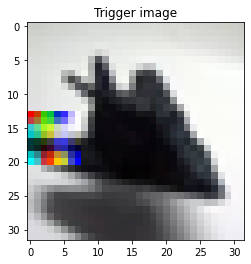

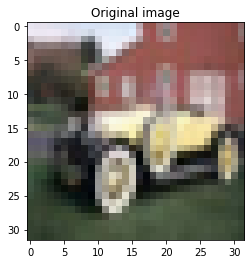

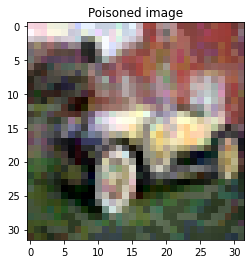

In [16]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison_[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()

# Calculate Success Rate on x_train and x_test

In [161]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (8,8,3))
patch = (patch-mean)/(std+1e-7)

def add_trigger_patch(x_set,patch_type="fixed"):
#     pdb.set_trace()
    print("patch_type",patch_type)
    # pdb.set_trace()
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (8,8,3))
    patch = (patch-mean)/(std+1e-7)
    if patch_type == "fixed":
        x_set[:,-8:,-8:,:] = patch
    else:
        for x in x_set:
            # x_cord = random.randint(0, 24)
            # y_cord = random.randint(0, 24)
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[x_cord:x_cord+8,y_cord:y_cord+8,:]=patch

    return x_set

# Calculate on train images

patch_type random
5000
Train Success Rate 0.3358


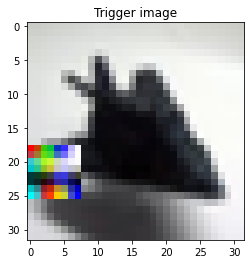

In [168]:
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train[index_source_train]
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned(torch.tensor(np.transpose(x_train_trigger, [0,3,1,2]), device=device, dtype=torch.float)).detach().cpu().numpy()
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==1).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(x_train_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

# Calculate Success Rate on Test 

patch_type random
1000
Test Success Rate: 0.365


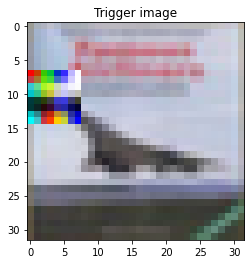

In [169]:
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned(torch.tensor(np.transpose(x_test_trigger, [0,3,1,2]), device=device, dtype=torch.float)).detach().cpu().numpy()
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(x_test_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()